<a href="https://colab.research.google.com/github/germfsip/2132InteligeciaArtificial/blob/main/Laboratorio7IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visión Computacional
## Dr. Gerardo Mtz
## Lección 7 - Redes Neuronales convolucionales


Primeramente importamos unos paquetes

In [1]:
# Importamos numpy y matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Importamos lo necesario para crear la red
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend

# Importamos unos paquetes de sklearn para comprobar el modelo
from sklearn.metrics import classification_report, confusion_matrix

Cargamos el dataset de MNIST

In [2]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Mostrartemos un ejemplo de manera aleatoria

Text(0.5, 1.0, 'Label: 2')

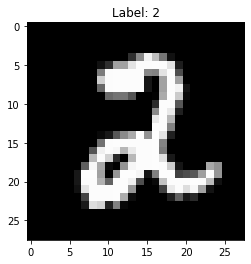

In [3]:
sample = np.random.randint(0,60000)
plt.imshow(xtrain[sample], cmap=plt.cm.gray)
plt.title('Label: ' + str(ytrain[sample]))

In [4]:
xtrain = xtrain.astype('float32')/255
xtest = xtest.astype('float32')/255

if backend.image_data_format() == 'channels_first':
    xtrain = xtrain.reshape(xtrain.shape[0], 1, 28, 28)
    xtest = xtest.reshape(xtest.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    xtrain = xtrain.reshape(xtrain.shape[0], 28, 28, 1)
    xtest = xtest.reshape(xtest.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

print(xtrain.shape)
print(input_shape)

(60000, 28, 28, 1)
(28, 28, 1)


In [5]:
print(ytrain[0])
ytrain = keras.utils.to_categorical(ytrain, 10)
print(ytrain[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
def build_model():
  model = Sequential()

  model.add(Conv2D(32,kernel_size=(3,3),
                   activation='relu',
                   input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer = 'adam',
                metrics=['accuracy'])
  return model

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [8]:
model.fit(xtrain, ytrain, batch_size=256, epochs=12, verbose=1,
          validation_split=0.17)

Epoch 1/12
195/195 [==============================] - 22s 34ms/step - loss: 1.3930 - accuracy: 0.5161 - val_loss: 0.1692 - val_accuracy: 0.9492
Epoch 2/12
195/195 [==============================] - 6s 31ms/step - loss: 0.2919 - accuracy: 0.9122 - val_loss: 0.0980 - val_accuracy: 0.9712
Epoch 3/12
195/195 [==============================] - 6s 31ms/step - loss: 0.2019 - accuracy: 0.9409 - val_loss: 0.0873 - val_accuracy: 0.9736
Epoch 4/12
195/195 [==============================] - 6s 31ms/step - loss: 0.1577 - accuracy: 0.9545 - val_loss: 0.0668 - val_accuracy: 0.9799
Epoch 5/12
195/195 [==============================] - 6s 32ms/step - loss: 0.1324 - accuracy: 0.9615 - val_loss: 0.0621 - val_accuracy: 0.9822
Epoch 6/12
195/195 [==============================] - 6s 32ms/step - loss: 0.1232 - accuracy: 0.9634 - val_loss: 0.0592 - val_accuracy: 0.9821
Epoch 7/12
195/195 [==============================] - 6s 31ms/step - loss: 0.1078 - accuracy: 0.9676 - val_loss: 0.0540 - val_accuracy: 0.983

In [9]:
ypred=model.predict(xtest)
print('Salida de la red:\n', ypred[0])

Salida de la red:
 [1.6862887e-09 1.3162610e-05 2.9644189e-05 7.0829151e-06 1.3477598e-08
 1.2317407e-08 1.2528044e-12 9.9994779e-01 6.4415133e-08 2.2188742e-06]


In [10]:
ypred = np.argmax(ypred, axis=1)
print('Predicciones:\n', ypred)

Predicciones:
 [7 2 1 ... 4 5 6]


In [11]:
print('Reporte de clasificación:\n', classification_report(ytest, ypred))
print('Matriz de confusión:\n', confusion_matrix(ytest, ypred))

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Matriz de confusión:
 [[ 971    2    1    1    0    0    1    3    0    1]
 [   0 1132    0    2    0    0    1    0    0    0]
 [   2    1 1012    3    0    0    1   13    0    0]
 [   0    1    1 1005    0    1  

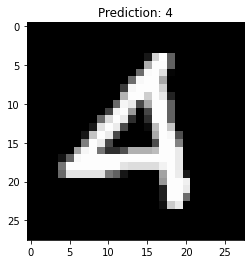

In [12]:
sample = np.random.randint(0,10000)
x = xtest[sample].reshape(28,28)
plt.imshow(x, cmap=plt.cm.gray)
plt.title('Prediction: ' + str(ypred[sample]))
plt.show()